In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def algorithm(algoname,colors,train,test,pos):
    mean_tpr,lw,i =0.0, 2,1
    mean_fpr = np.linspace(0, 1, 100)
    fold_accuracy= []
    skfold = StratifiedKFold(n_splits=10,shuffle = True)
    for (trainindex,testindex), color in zip(skfold.split(train, test.values.ravel()), colors):
        X_train, X_test = train.loc[trainindex], train.loc[testindex]
        y_train, y_test = test.loc[trainindex], test.loc[testindex]
        model = algoname.fit(X_train,y_train.values.ravel())
        fold_accuracy.append(model.score(X_test,y_test.values.ravel()))
        result = model.predict(X_test)
        fpr, tpr, thresholds= roc_curve(y_test.values,result,pos_label=pos)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.step(fpr, tpr, lw=lw, color=color,label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i+=1
    mean_tpr /= skfold.get_n_splits(train,test.values.ravel())
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.step(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.title("Average accuracy: {0:.3f}".format(np.asarray(fold_accuracy).mean()))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right") 
    return ("Average accuracy: {0:.3f} (+/-{1:.3f})".format(np.asarray(fold_accuracy).mean(),\
                                                            np.asarray(fold_accuracy).std()))    

In [3]:
import math
import operator
def euclidean_distance(data1,data2):
    result = 0.0
    for val in range(len(data2)):
        result += (data1[val]-data2[val])**2
    return math.sqrt(result)
def knn(train,test,k):
    dist,kneighbors = [],[]
    for a,c in train.iterrows():
        distance = euclidean_distance(c,test)
        dist.append((c,distance))
        dist.sort(key=operator.itemgetter(1))
    for i in range(k):
        kneighbors.append(dist[i][0])
    return kneighbors  
def majorityVote(kneighbors):
    vote = {}
    for i in range(len(kneighbors)):
        lst = kneighbors[i][-1]
        if lst in vote:
            vote[lst]+=1
        else:
            vote[lst]=1
    majority = max(vote.items(), key=operator.itemgetter(1))[0]
    return majority

In [4]:
german = pd.read_csv('german.data',header = None, sep = " ")
features = ['Checking account','Duration(month)','Credit history','Purpose',\
           'Credit Amount','Savings/Stocks','Present employment Length',\
           'Installment rate','Personal status','Guarantors',\
           'Residing since','Property','Age(years)','Other installment plans',\
           'Housing','No of credits',\
           'Job','dependents','Telephone','foreign worker']
label = ['Creditability']
columns = features + label
german.columns = columns
german.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Checking account             1000 non-null object
Duration(month)              1000 non-null int64
Credit history               1000 non-null object
Purpose                      1000 non-null object
Credit Amount                1000 non-null int64
Savings/Stocks               1000 non-null object
Present employment Length    1000 non-null object
Installment rate             1000 non-null int64
Personal status              1000 non-null object
Guarantors                   1000 non-null object
Residing since               1000 non-null int64
Property                     1000 non-null object
Age(years)                   1000 non-null int64
Other installment plans      1000 non-null object
Housing                      1000 non-null object
No of credits                1000 non-null int64
Job                          1000 non-null object
dependents                   1000 non-null int64
T

# Exploratory Data Analysis

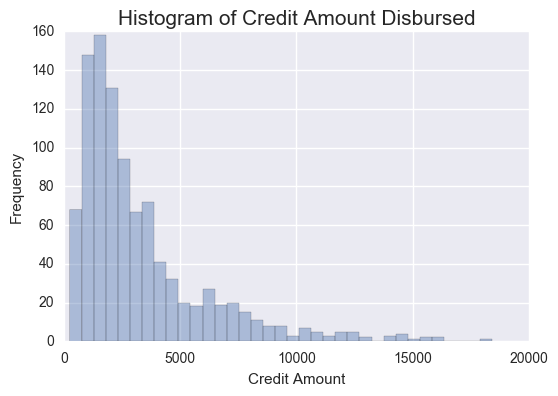

In [5]:
sns.distplot( german['Credit Amount'], kde = False )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")

In [6]:
german['Creditability'].value_counts()

1    700
2    300
Name: Creditability, dtype: int64

In [7]:
for col in german.columns.values:
    if german[col].dtype == 'object':
        german[col] = LabelEncoder().fit_transform(german[col])
german_train,german_test = german[features],german[label]

In [8]:
estimators = [10,100,300,600,800,1000]
depth = [1,2,50,100,300,800,None]
features = ['auto','sqrt',0.2, None]
min_sampleleaf = [1,5,10,50,100,200,500]
randomstate = [1,50,100,500,None]
colors = cycle(['brown','lightcoral','red','magenta','cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
penalties = ['l1','l2']
cvalue = [1.0,0.1,0.5,0.8,0.9]
solve = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
tolerance = []
classweight = ['balanced',None]
max_iter = [10,100,500,1000]
randomState = [None,10,100,500,1000,1024]
neighbors = [5,10,50,100]
weight = ['uniform','distance']
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
dual = [True,False]

# Random Forest 

Estimators - Number of tress in the forest

Average accuracy: 0.752 (+/-0.033) estimators:  10
Average accuracy: 0.770 (+/-0.041) estimators:  100
Average accuracy: 0.764 (+/-0.038) estimators:  300
Average accuracy: 0.765 (+/-0.036) estimators:  600
Average accuracy: 0.775 (+/-0.032) estimators:  800
Average accuracy: 0.769 (+/-0.035) estimators:  1000


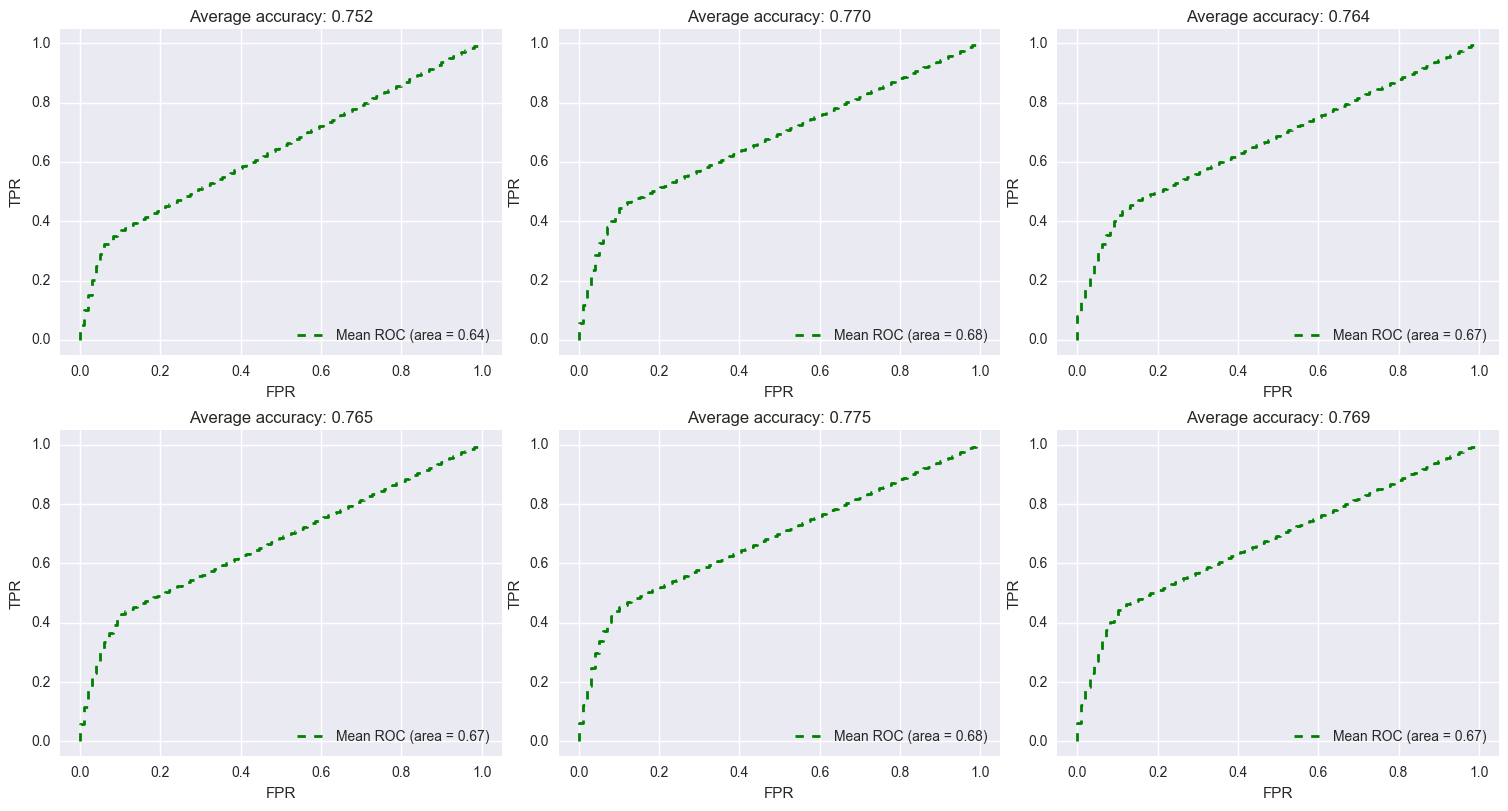

In [9]:
plt.figure(figsize=(15,8))

for i in range(len(estimators)):
    forest = RandomForestClassifier(n_estimators=estimators[i], n_jobs=-1)
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"estimators: ",estimators[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Maximum Depth of Tree

Average accuracy: 0.700 (+/-0.000) maximum depth:  1
Average accuracy: 0.702 (+/-0.004) maximum depth:  2
Average accuracy: 0.771 (+/-0.023) maximum depth:  50
Average accuracy: 0.766 (+/-0.029) maximum depth:  100
Average accuracy: 0.769 (+/-0.033) maximum depth:  300
Average accuracy: 0.774 (+/-0.034) maximum depth:  800
Average accuracy: 0.761 (+/-0.034) maximum depth:  None


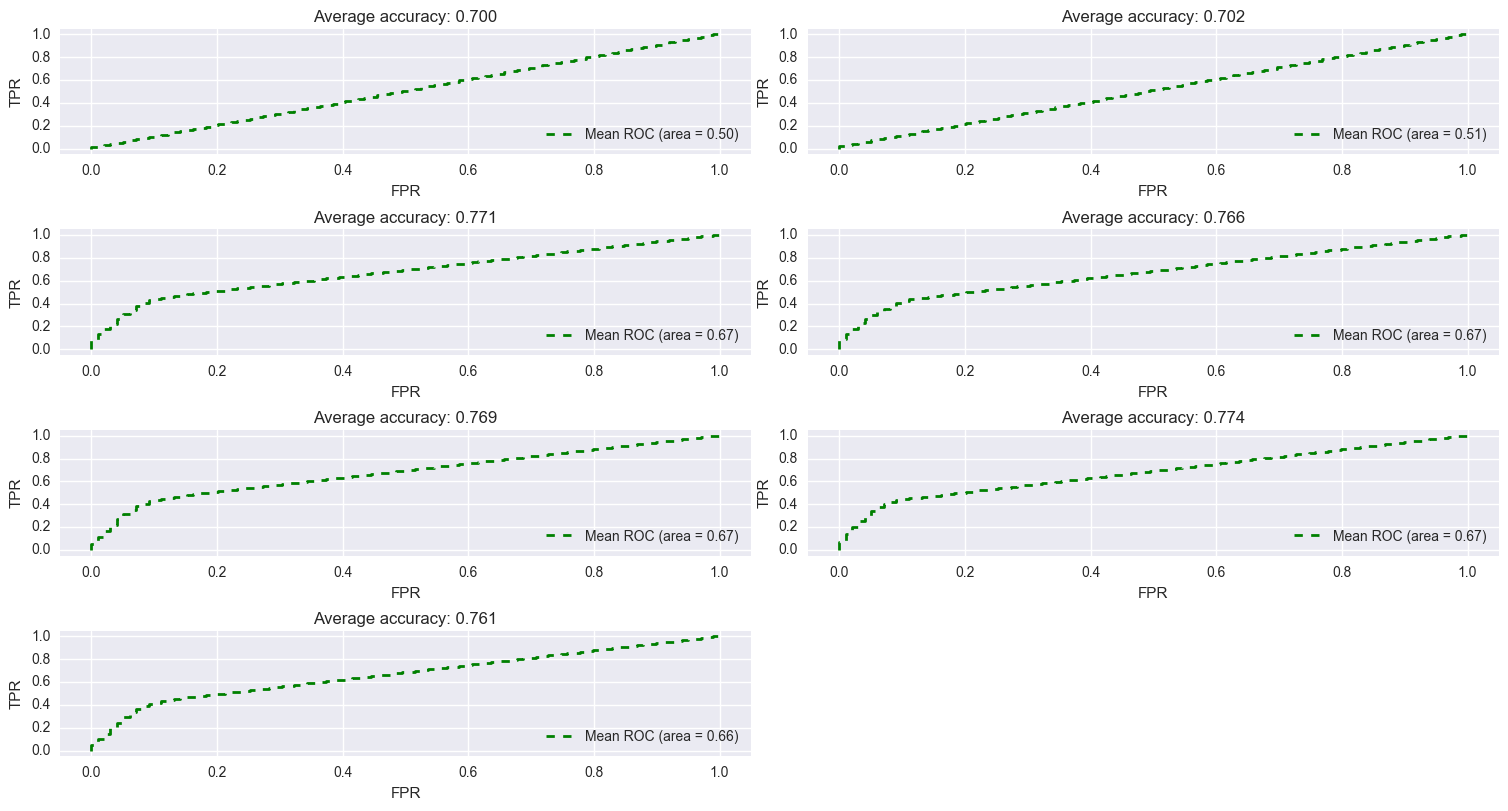

In [10]:
plt.figure(figsize=(15,8))
for i in range(len(depth)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = depth[i])
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"maximum depth: ",depth[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

The number of features to consider when looking for the best split

Average accuracy: 0.769 (+/-0.032) max features:  auto
Average accuracy: 0.758 (+/-0.031) max features:  sqrt
Average accuracy: 0.765 (+/-0.026) max features:  0.2
Average accuracy: 0.767 (+/-0.025) max features:  None


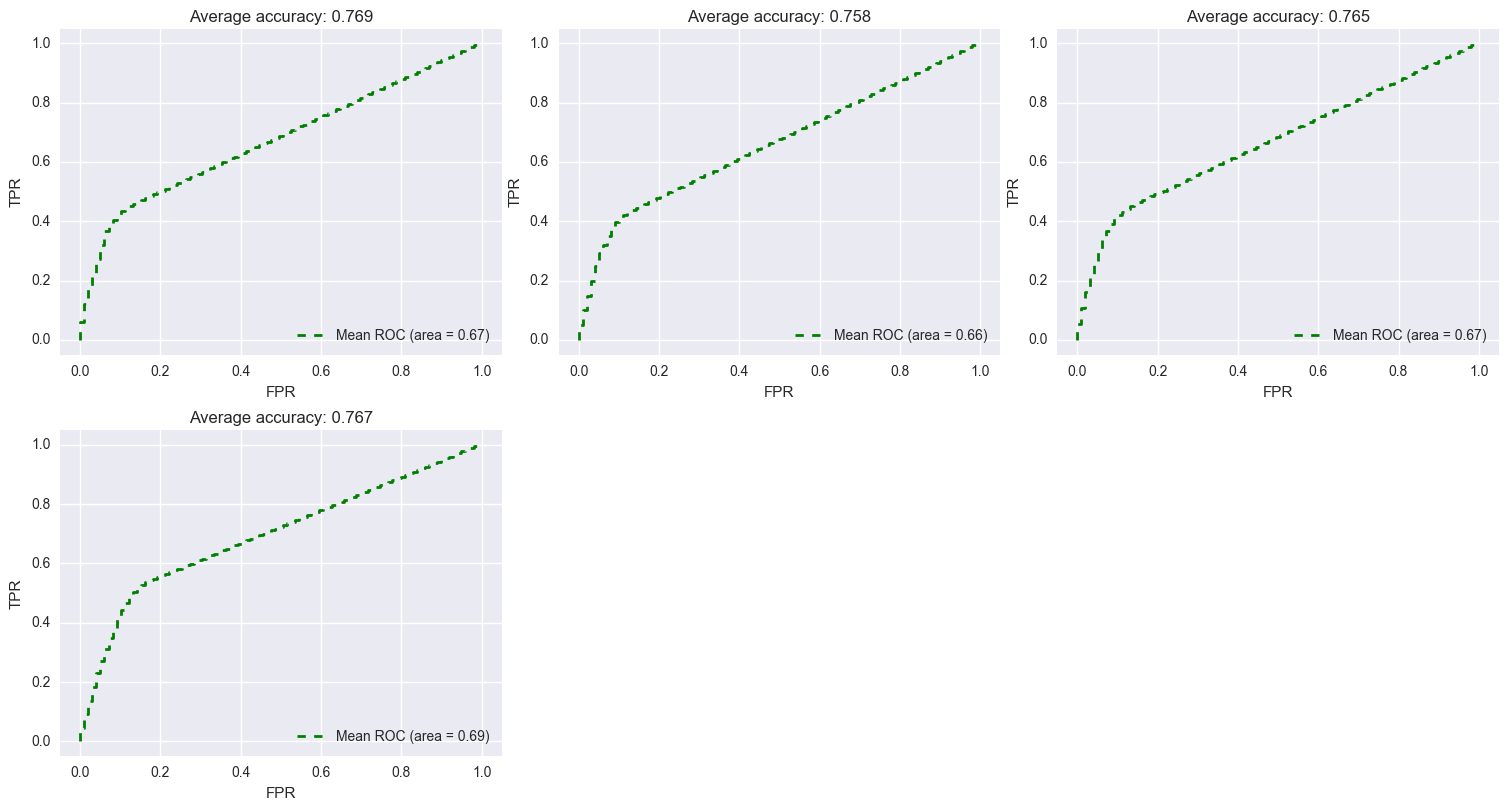

In [11]:
plt.figure(figsize=(15,8))
for i in range(len(features)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,\
                                    max_features = features[i])
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"max features: ",features[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

the minimum number of samples required to be at a leaf node

Average accuracy: 0.764 (+/-0.040) min sample leaf:  1
Average accuracy: 0.771 (+/-0.029) min sample leaf:  5
Average accuracy: 0.756 (+/-0.032) min sample leaf:  10
Average accuracy: 0.708 (+/-0.012) min sample leaf:  50
Average accuracy: 0.700 (+/-0.000) min sample leaf:  100
Average accuracy: 0.700 (+/-0.000) min sample leaf:  200
Average accuracy: 0.700 (+/-0.000) min sample leaf:  500


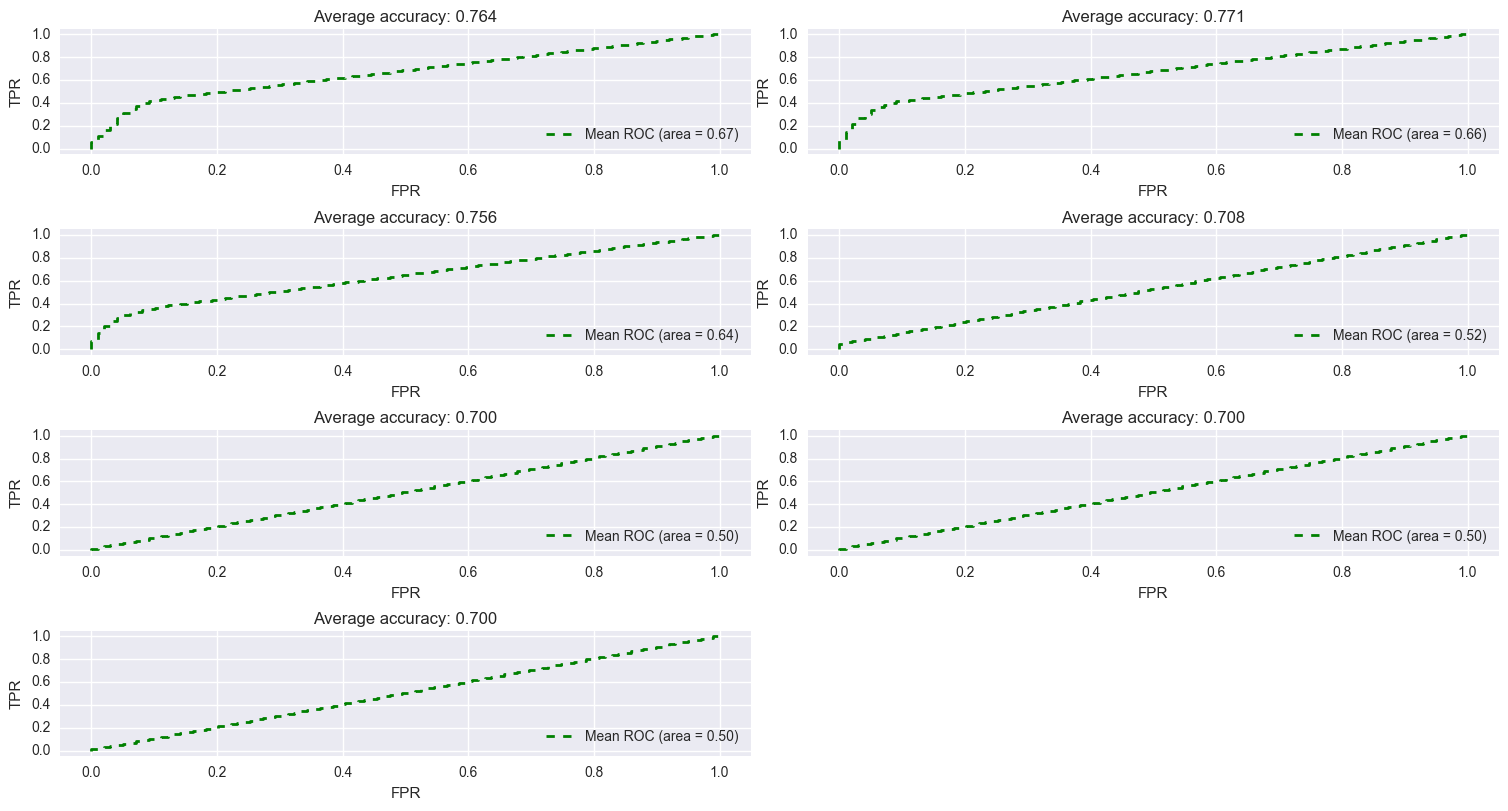

In [12]:
plt.figure(figsize=(15,8))
for i in range(len(min_sampleleaf)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =min_sampleleaf[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"min sample leaf: ",min_sampleleaf[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

random_state is the seed used by the random number generator

Average accuracy: 0.706 (+/-0.010) random state:  1
Average accuracy: 0.713 (+/-0.011) random state:  50
Average accuracy: 0.710 (+/-0.013) random state:  100
Average accuracy: 0.706 (+/-0.011) random state:  500
Average accuracy: 0.709 (+/-0.009) random state:  None


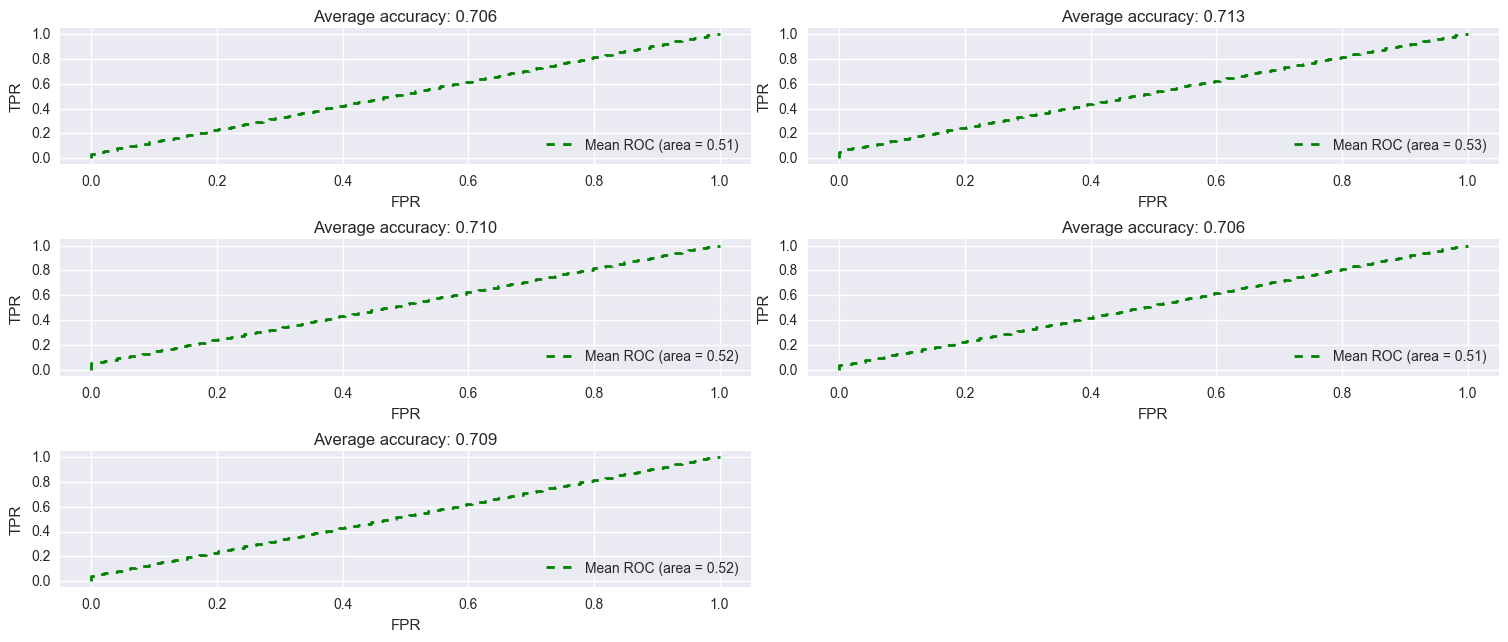

In [13]:
plt.figure(figsize=(15,8))
for i in range(len(randomstate)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =50,random_state=randomstate[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"random state: ",randomstate[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Best Parameters using Greedy Approach

Average accuracy: 0.707 (+/-0.013)


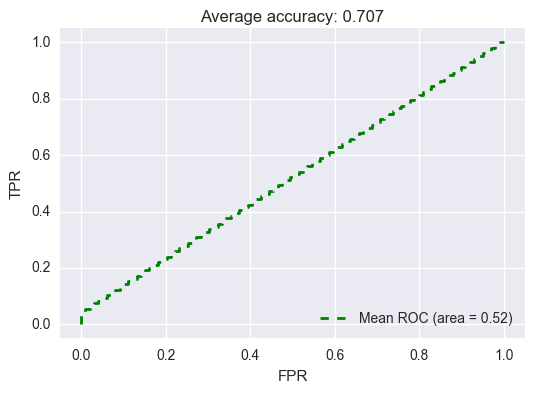

In [14]:
forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =50,random_state = None)
print(algorithm(forest,colors,german_train,german_test,pos = 2))

Random Forest Best Parameters

In [15]:
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=800, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

# Logistic Regression

L1 or L2 regularization?

Average accuracy: 0.760 (+/-0.024) Penalty:  l1
Average accuracy: 0.762 (+/-0.054) Penalty:  l2


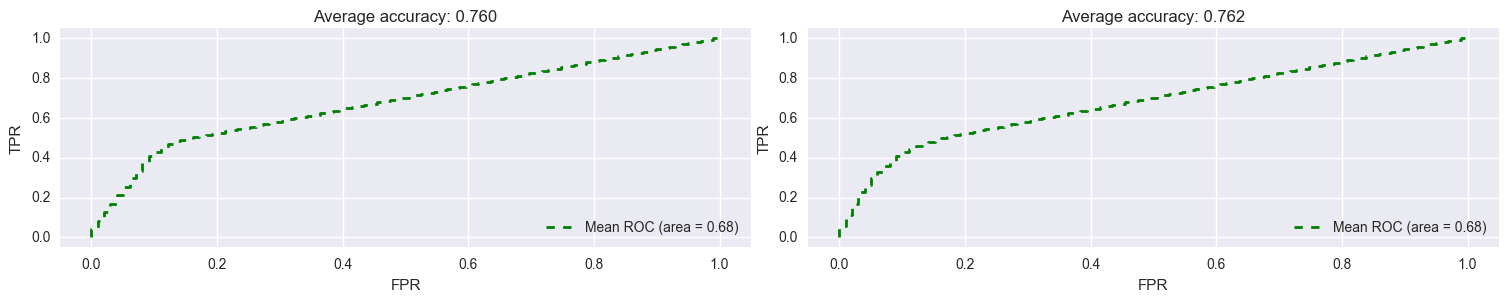

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    logistic = LogisticRegression(n_jobs = -1, penalty= penalties[i])
    plt.subplot(3,2,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Algorithm to use in the optimization problem?

Average accuracy: 0.758 (+/-0.046) Solver:  newton-cg
Average accuracy: 0.752 (+/-0.044) Solver:  lbfgs
Average accuracy: 0.758 (+/-0.040) Solver:  liblinear
Average accuracy: 0.700 (+/-0.000) Solver:  sag


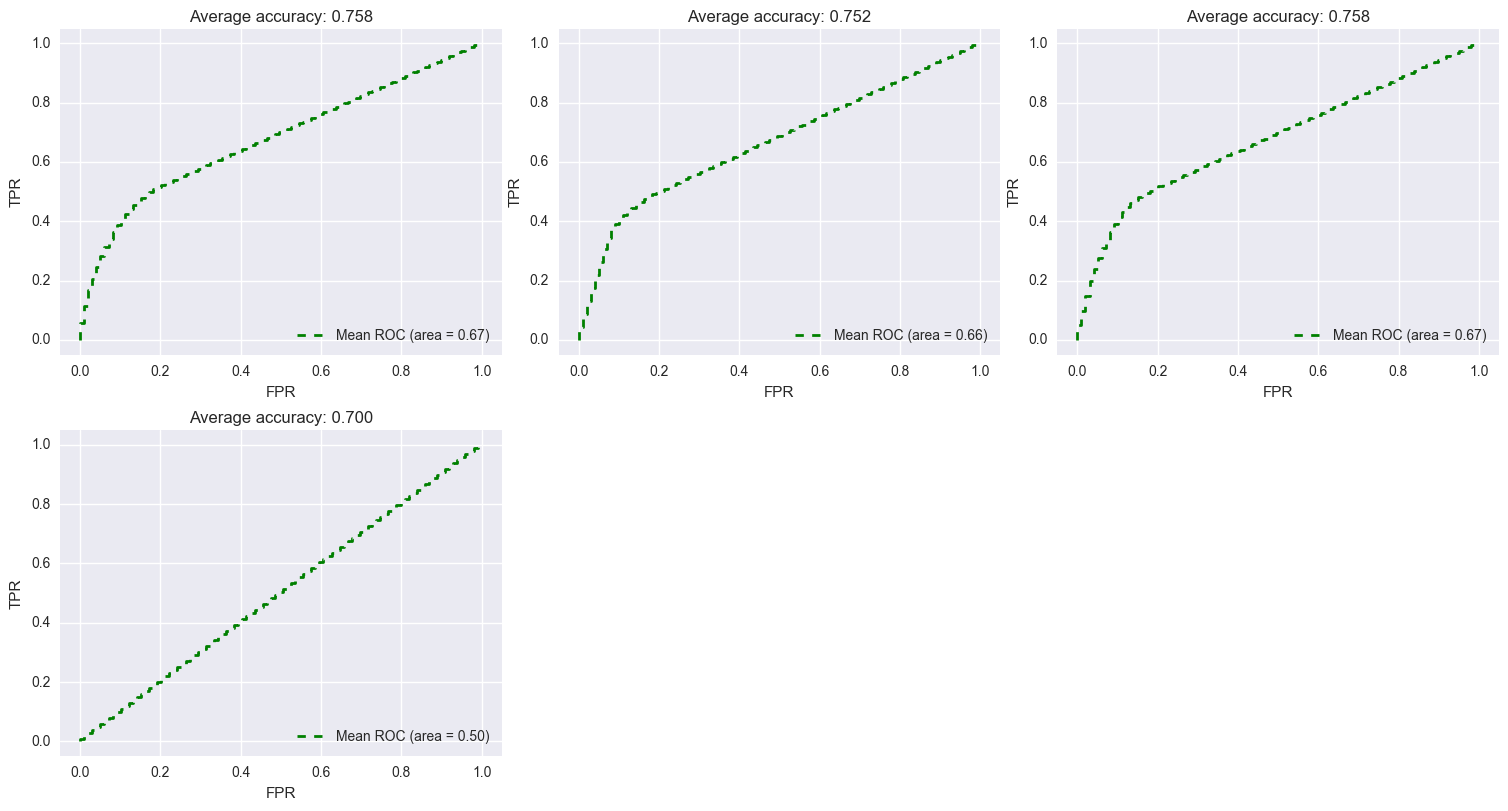

In [17]:
plt.figure(figsize=(15,8))
for i in range(len(solve)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2',  solver = solve[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Solver: ",solve[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

C Value: Inverse of regularization strength

Average accuracy: 0.758 (+/-0.052) C:  1.0
Average accuracy: 0.754 (+/-0.031) C:  0.1
Average accuracy: 0.758 (+/-0.032) C:  0.5
Average accuracy: 0.759 (+/-0.039) C:  0.8
Average accuracy: 0.756 (+/-0.039) C:  0.9


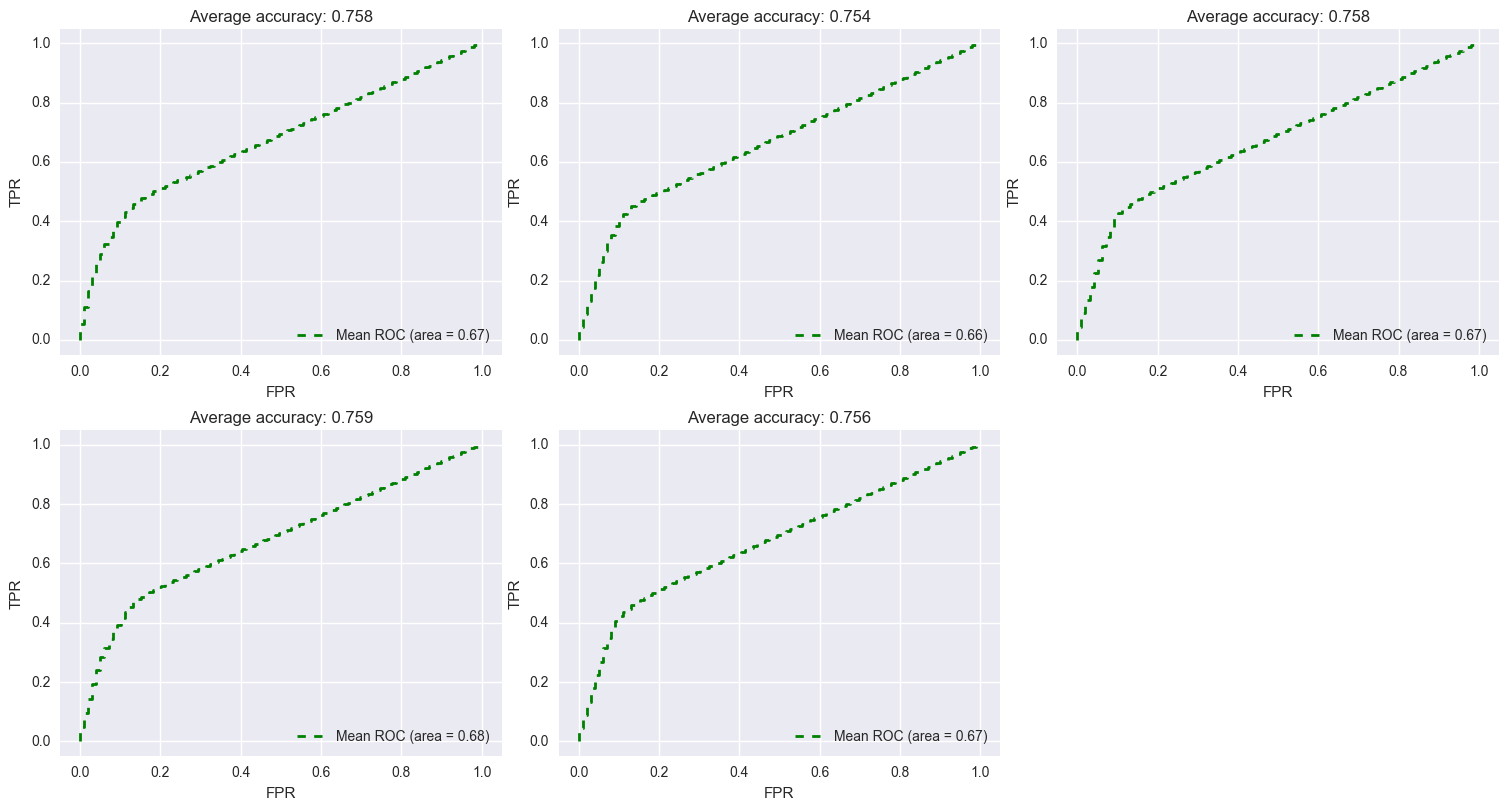

In [18]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', solver = 'liblinear', C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Weights associated with classes

Average accuracy: 0.720 (+/-0.057) Class Weight:  balanced
Average accuracy: 0.760 (+/-0.037) Class Weight:  None


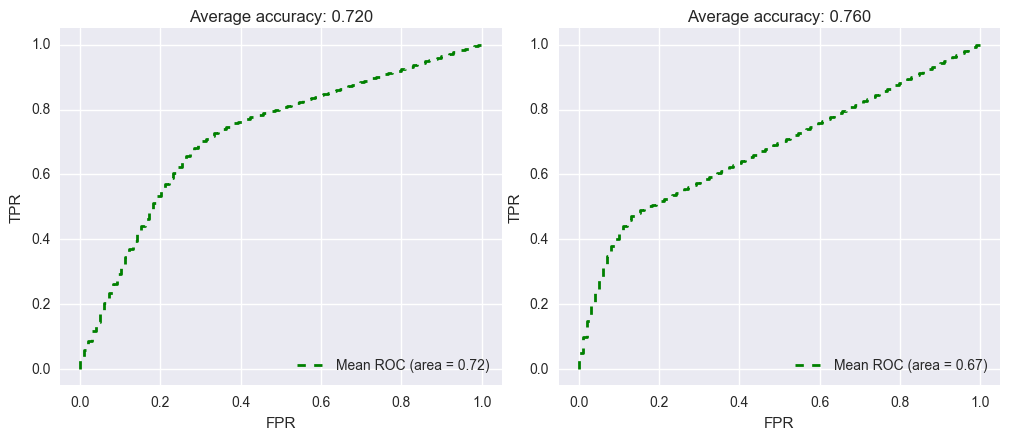

In [19]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Maximum Iteration

Average accuracy: 0.710 (+/-0.023) Max iterations:  10
Average accuracy: 0.755 (+/-0.037) Max iterations:  100
Average accuracy: 0.755 (+/-0.029) Max iterations:  500
Average accuracy: 0.754 (+/-0.040) Max iterations:  1000


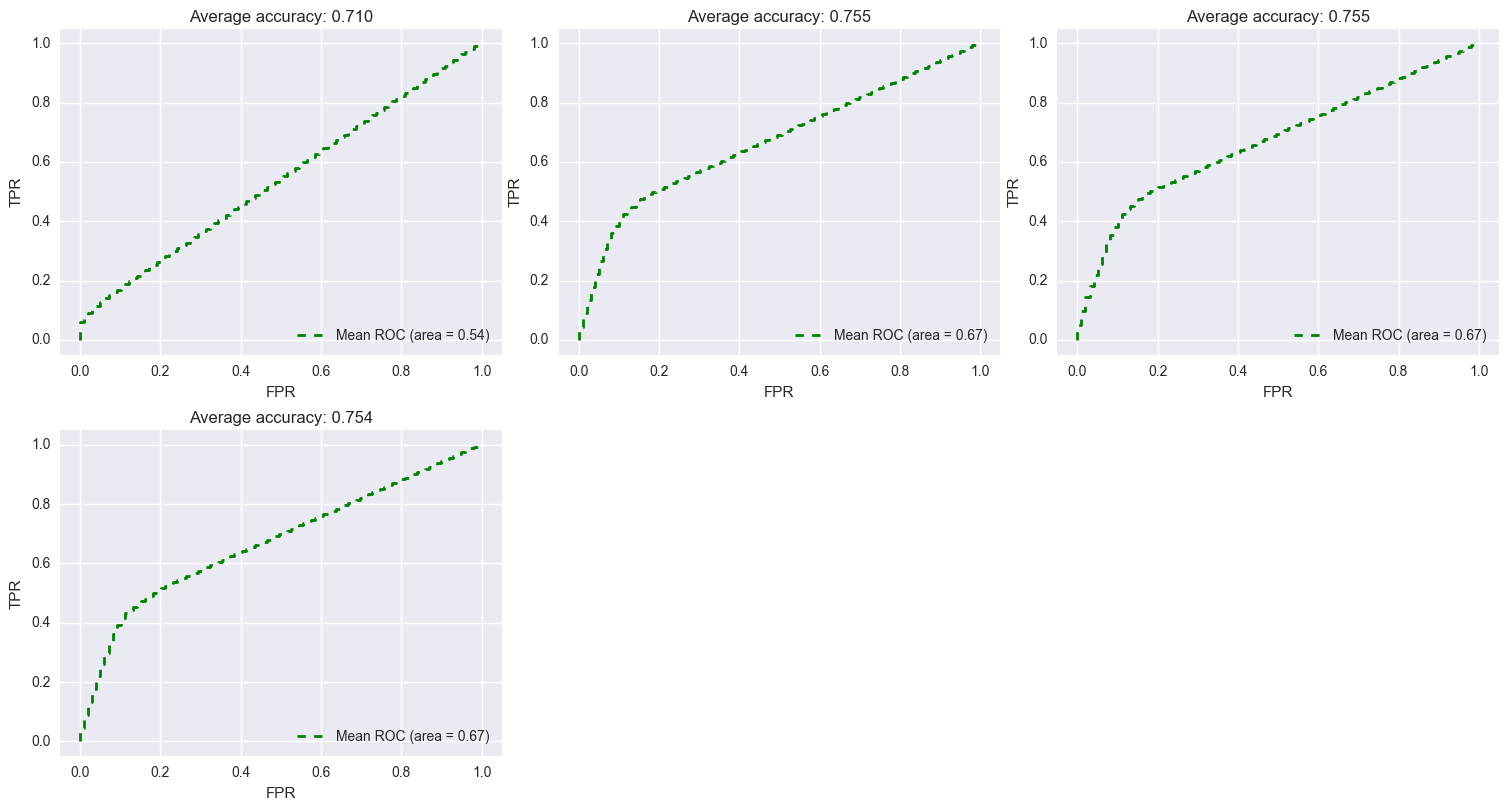

In [20]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None ,max_iter = max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Max iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Ignoring Maximum iterations because of two reasons:<br/>
1. Accuracy decreasing <br/>
2. Useful only for the newton-cg, sag and lbfgs solvers

Random State: The seed of the pseudo random number generator to use when shuffling the data

Average accuracy: 0.759 (+/-0.023) Random State:  None
Average accuracy: 0.750 (+/-0.030) Random State:  10
Average accuracy: 0.760 (+/-0.046) Random State:  100
Average accuracy: 0.759 (+/-0.038) Random State:  500
Average accuracy: 0.756 (+/-0.031) Random State:  1000
Average accuracy: 0.759 (+/-0.030) Random State:  1024


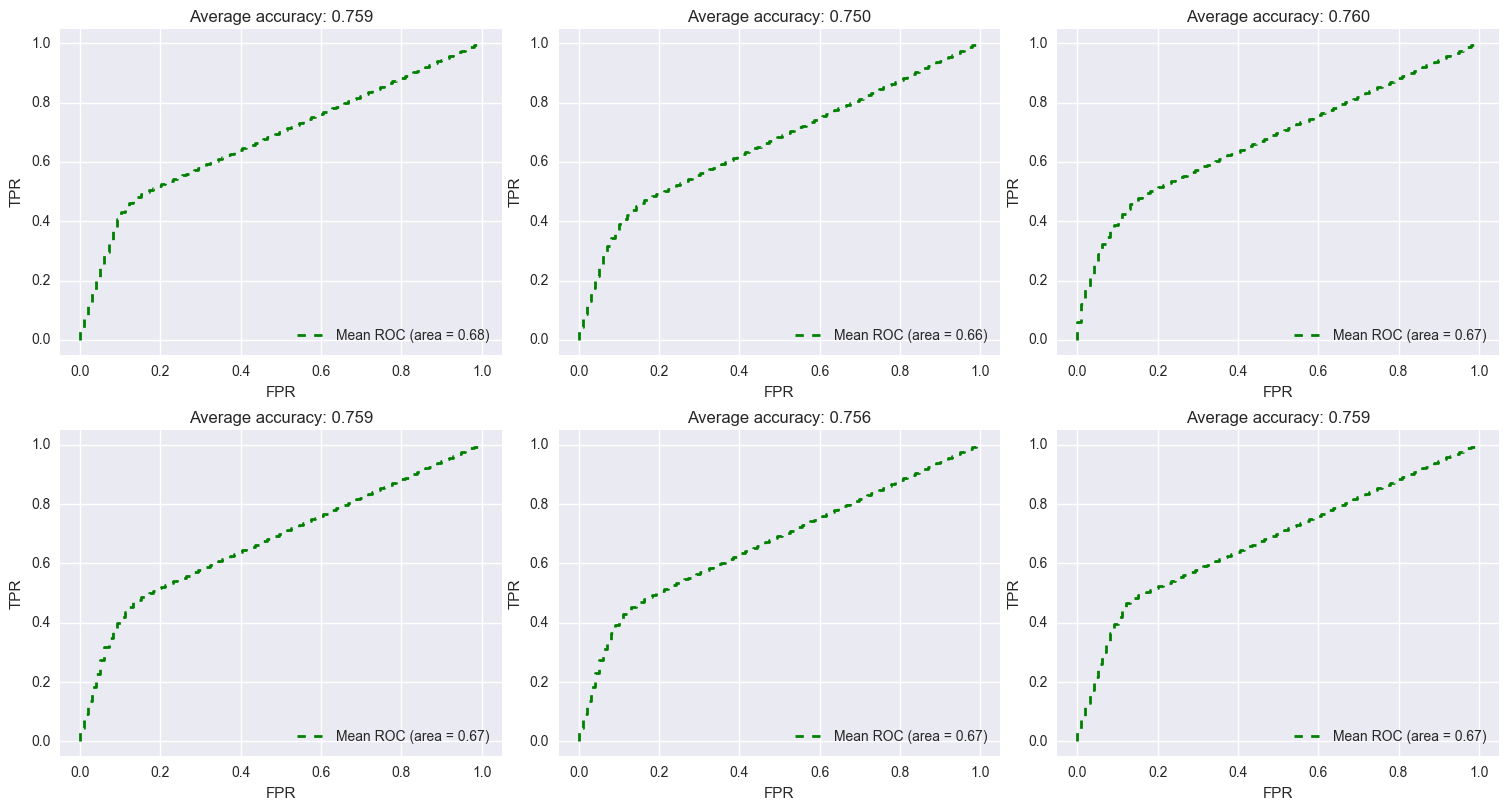

In [21]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None,random_state = randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Best Parameters using Greedy Approach

Average accuracy: 0.757 (+/-0.039)


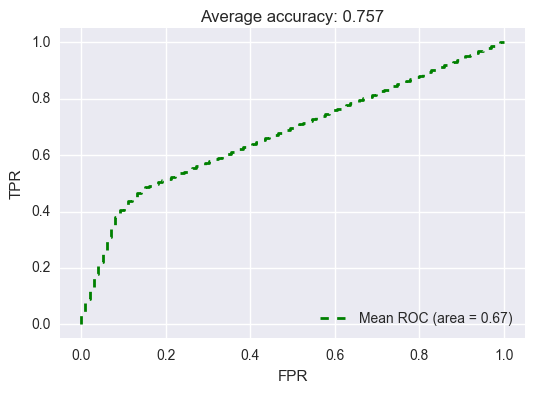

In [22]:
logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None,random_state = 500)
print(algorithm(logistic,colors,german_train,german_test,pos = 2))

Logistic Regression Best Parameters

In [23]:
logistic

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=500, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Naive Bayes

Average accuracy: 0.728 (+/-0.037)


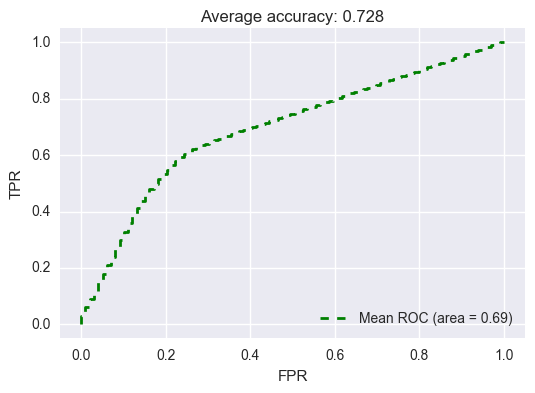

In [24]:
naive = GaussianNB()
print(algorithm(naive,colors,german_train,german_test,pos = 2))

Naive Bayes Best Parameters

In [25]:
naive

GaussianNB(priors=None)

# k Nearest Neighbors

Number of neighbors

Average accuracy: 0.651 (+/-0.039) Neighbors:  5
Average accuracy: 0.696 (+/-0.022) Neighbors:  10
Average accuracy: 0.706 (+/-0.017) Neighbors:  50
Average accuracy: 0.700 (+/-0.000) Neighbors:  100


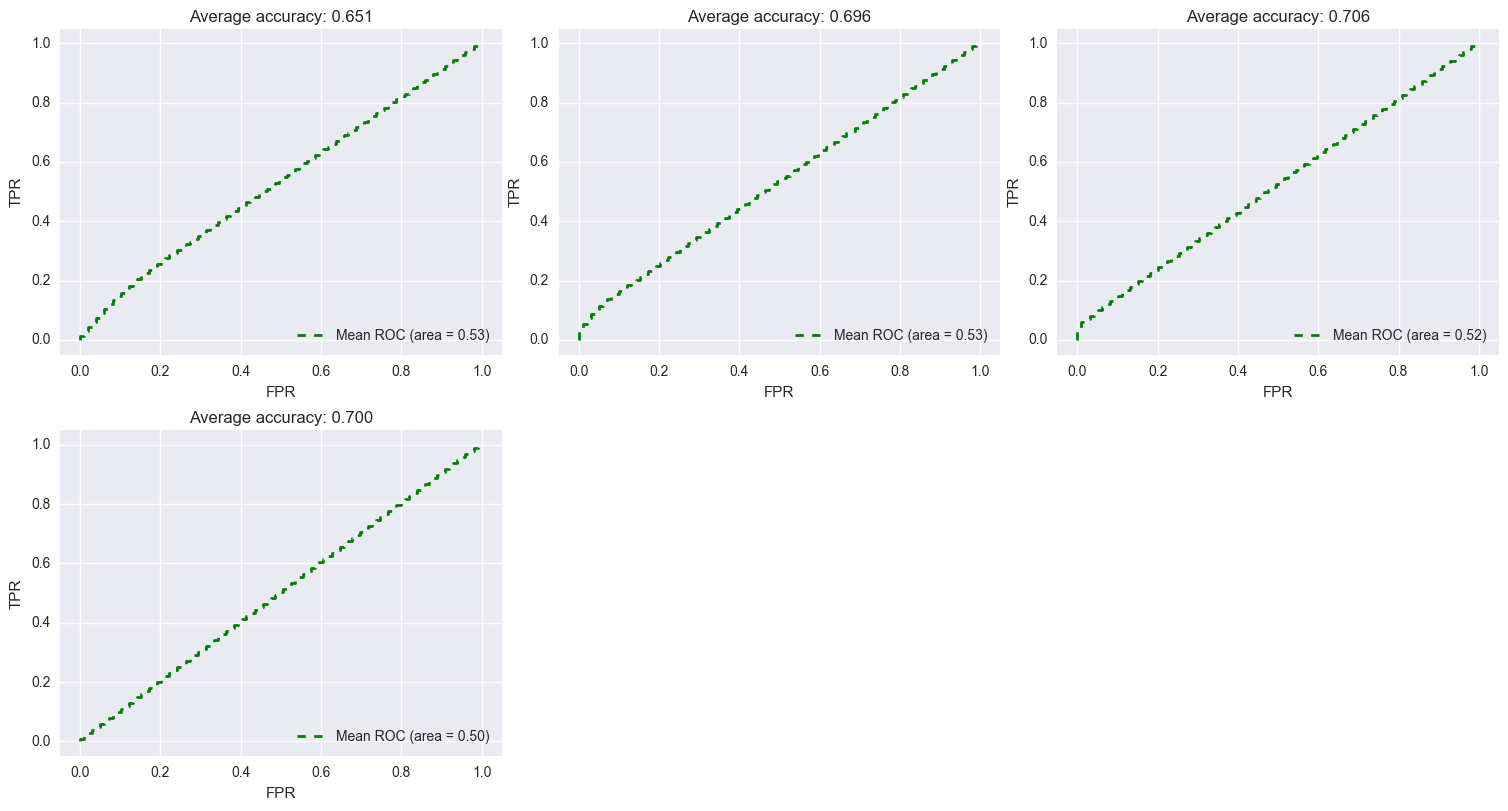

In [26]:
plt.figure(figsize=(15,8))
for i in range(len(neighbors)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors= neighbors[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Neighbors: ",neighbors[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

weight function used in prediction

Average accuracy: 0.643 (+/-0.041) Weights:  uniform
Average accuracy: 0.648 (+/-0.030) Weights:  distance


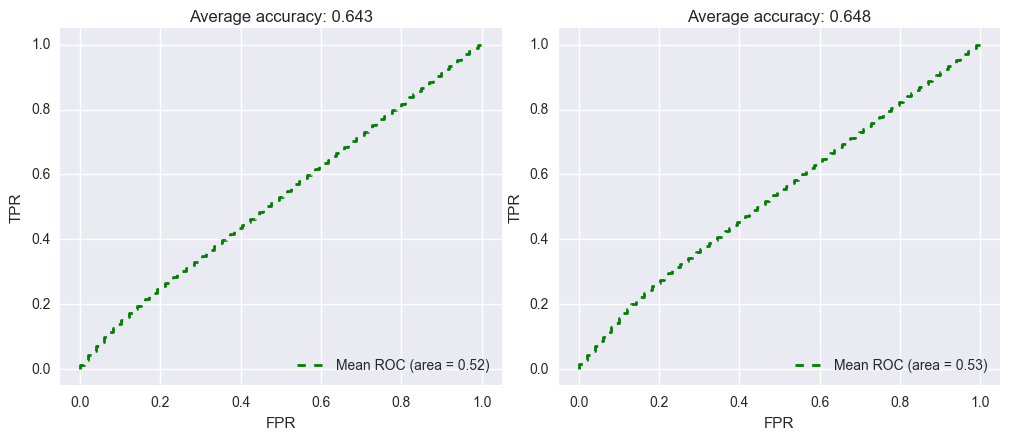

In [27]:
plt.figure(figsize=(15,8))
for i in range(len(weight)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = weight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Weights: ",weight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Algorithm used to compute the nearest neighbors

Average accuracy: 0.660 (+/-0.026) Algorithm:  auto
Average accuracy: 0.650 (+/-0.030) Algorithm:  ball_tree
Average accuracy: 0.645 (+/-0.044) Algorithm:  kd_tree
Average accuracy: 0.651 (+/-0.034) Algorithm:  brute


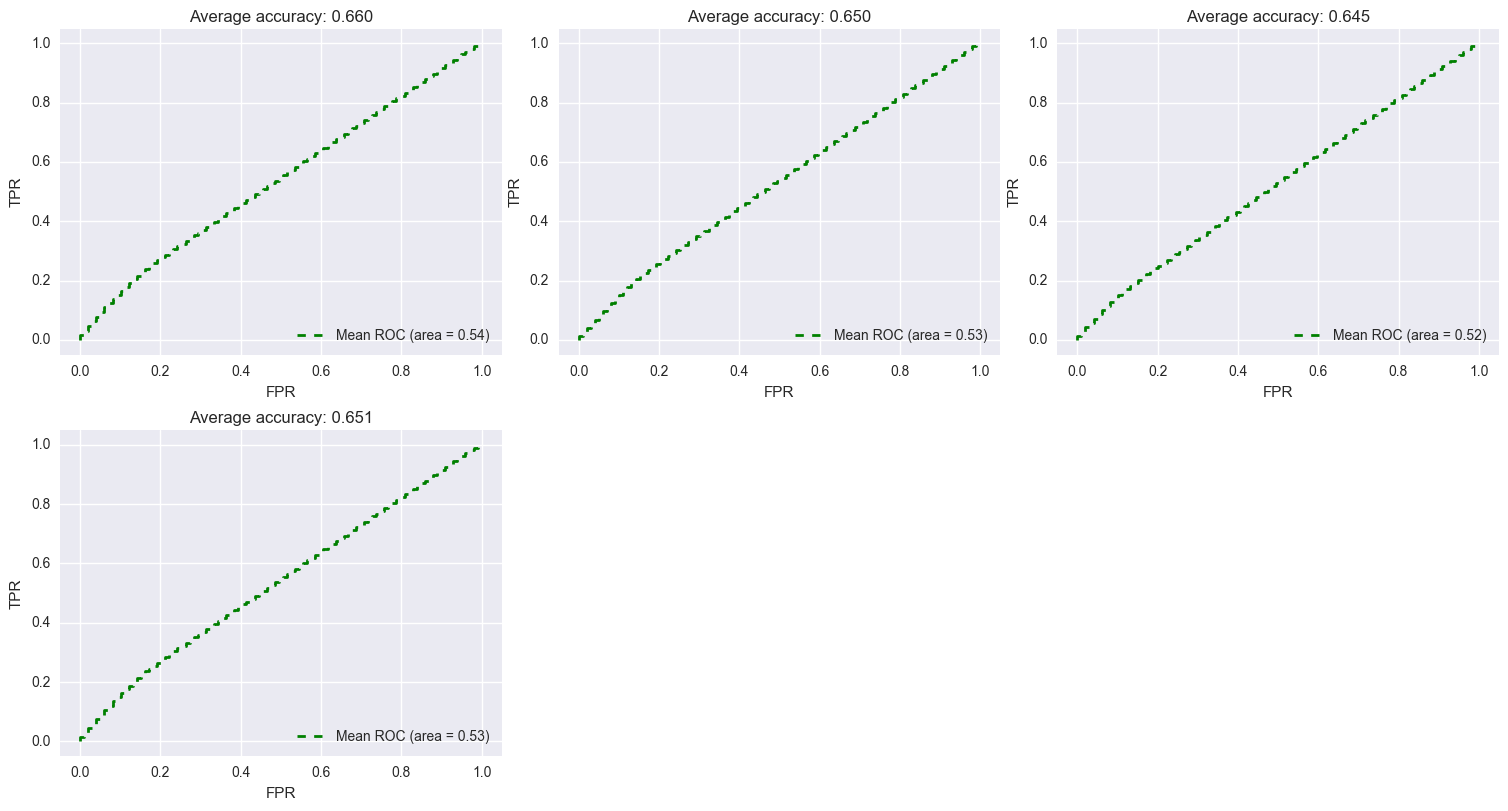

In [28]:
plt.figure(figsize=(15,8))
for i in range(len(algo)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = algo[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Algorithm: ",algo[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Best Parameters using Greedy Approach

Average accuracy: 0.664 (+/-0.035)


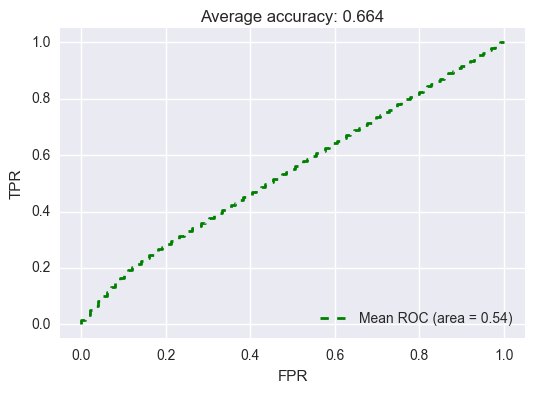

In [29]:
knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = 'auto')
print(algorithm(knneigh,colors,german_train,german_test,pos = 2))

k Nearest Neighbors Best Parameters

In [30]:
knneigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

# Support Vector Machines

Dual or primal optimization

Average accuracy: 0.537 (+/-0.165) Dual:  True
Average accuracy: 0.757 (+/-0.030) Dual:  False


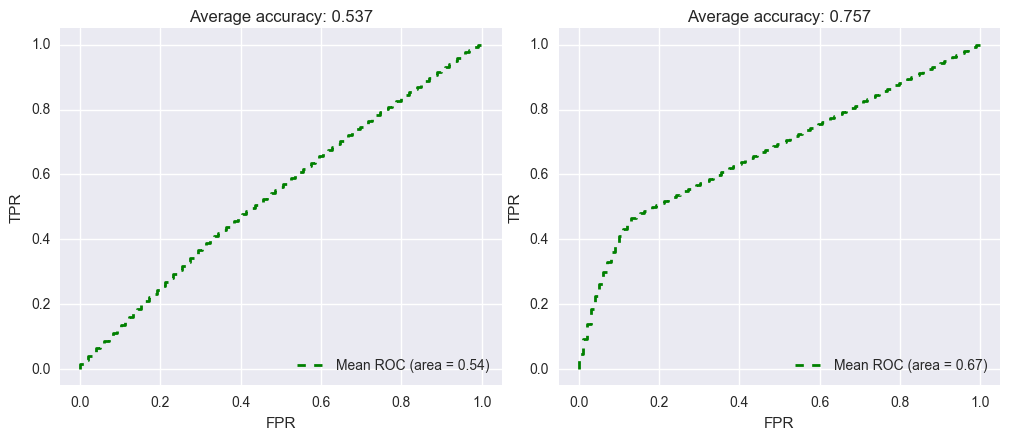

In [31]:
plt.figure(figsize=(15,8))
for i in range(len(dual)):
    svm = LinearSVC(dual = dual[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Dual: ",dual[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

C Value: Inverse of regularization strength

Average accuracy: 0.755 (+/-0.040) C:  1.0
Average accuracy: 0.761 (+/-0.034) C:  0.1
Average accuracy: 0.750 (+/-0.038) C:  0.5
Average accuracy: 0.763 (+/-0.026) C:  0.8
Average accuracy: 0.762 (+/-0.038) C:  0.9


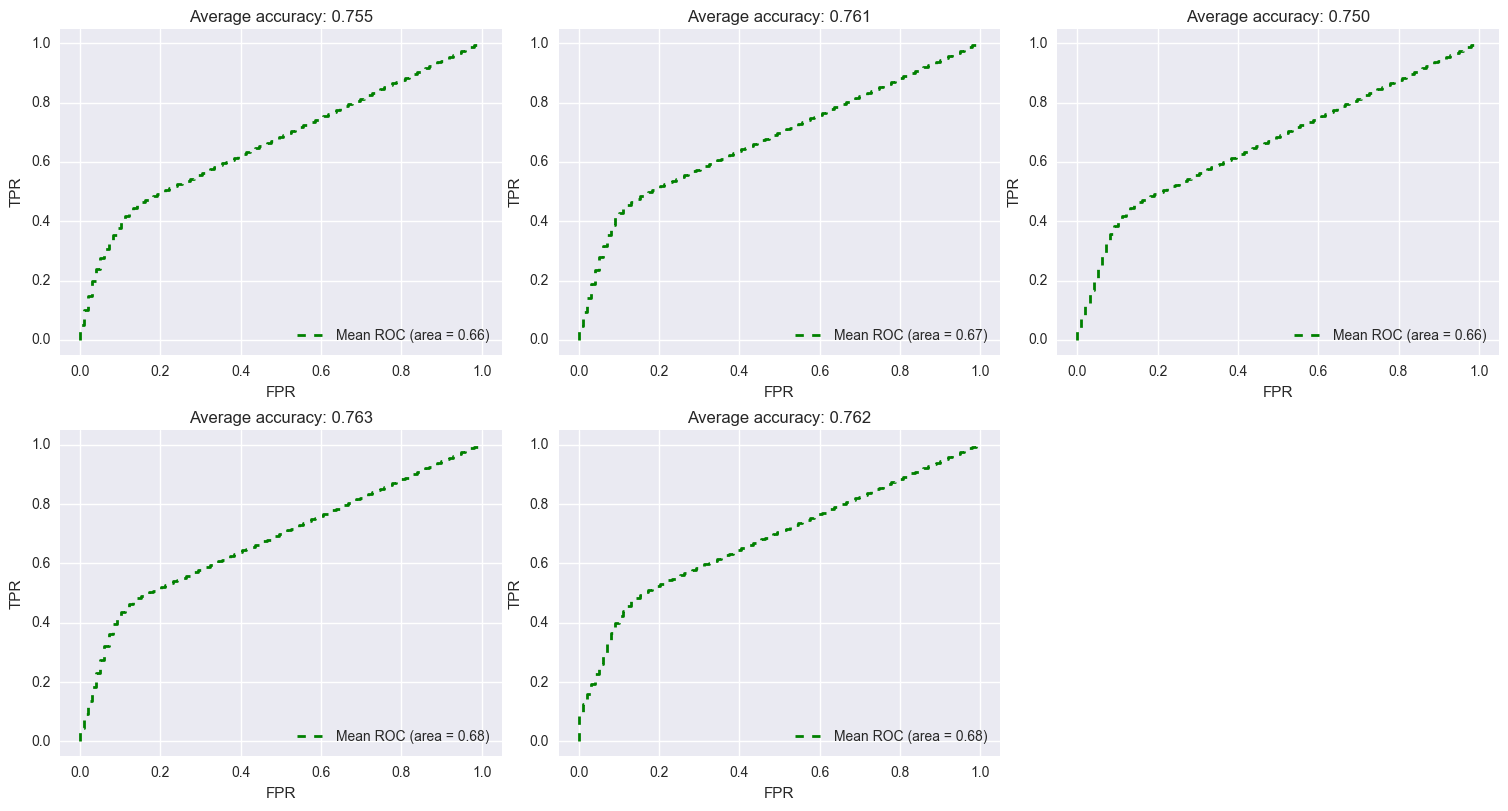

In [32]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    svm = LinearSVC(dual = False, C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

L1 or L2 regularization?

Average accuracy: 0.755 (+/-0.041) Penalty:  l1
Average accuracy: 0.761 (+/-0.023) Penalty:  l2


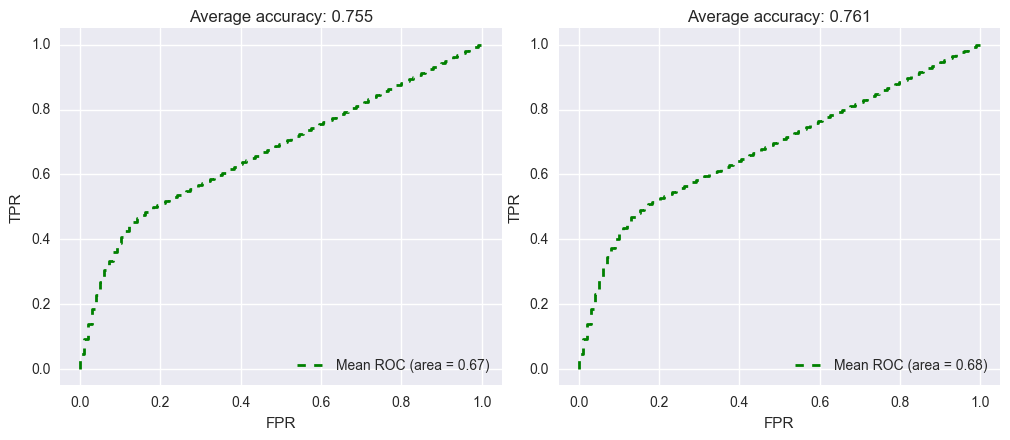

In [33]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    svm = LinearSVC(dual = False, C = 1, penalty = penalties[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

weight function used in prediction

Average accuracy: 0.707 (+/-0.043) Class Weight:  balanced
Average accuracy: 0.759 (+/-0.034) Class Weight:  None


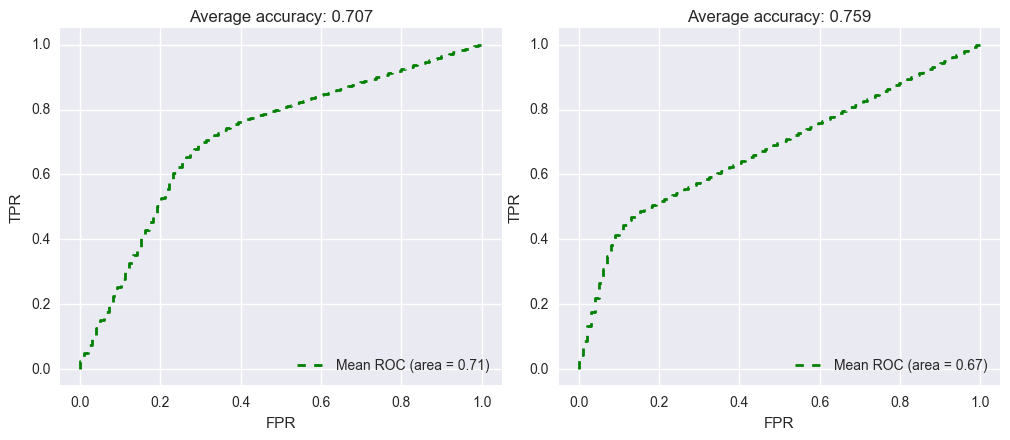

In [34]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Maximum Iteration

Average accuracy: 0.751 (+/-0.044) Max Iterations:  10
Average accuracy: 0.760 (+/-0.042) Max Iterations:  100
Average accuracy: 0.759 (+/-0.031) Max Iterations:  500
Average accuracy: 0.759 (+/-0.030) Max Iterations:  1000


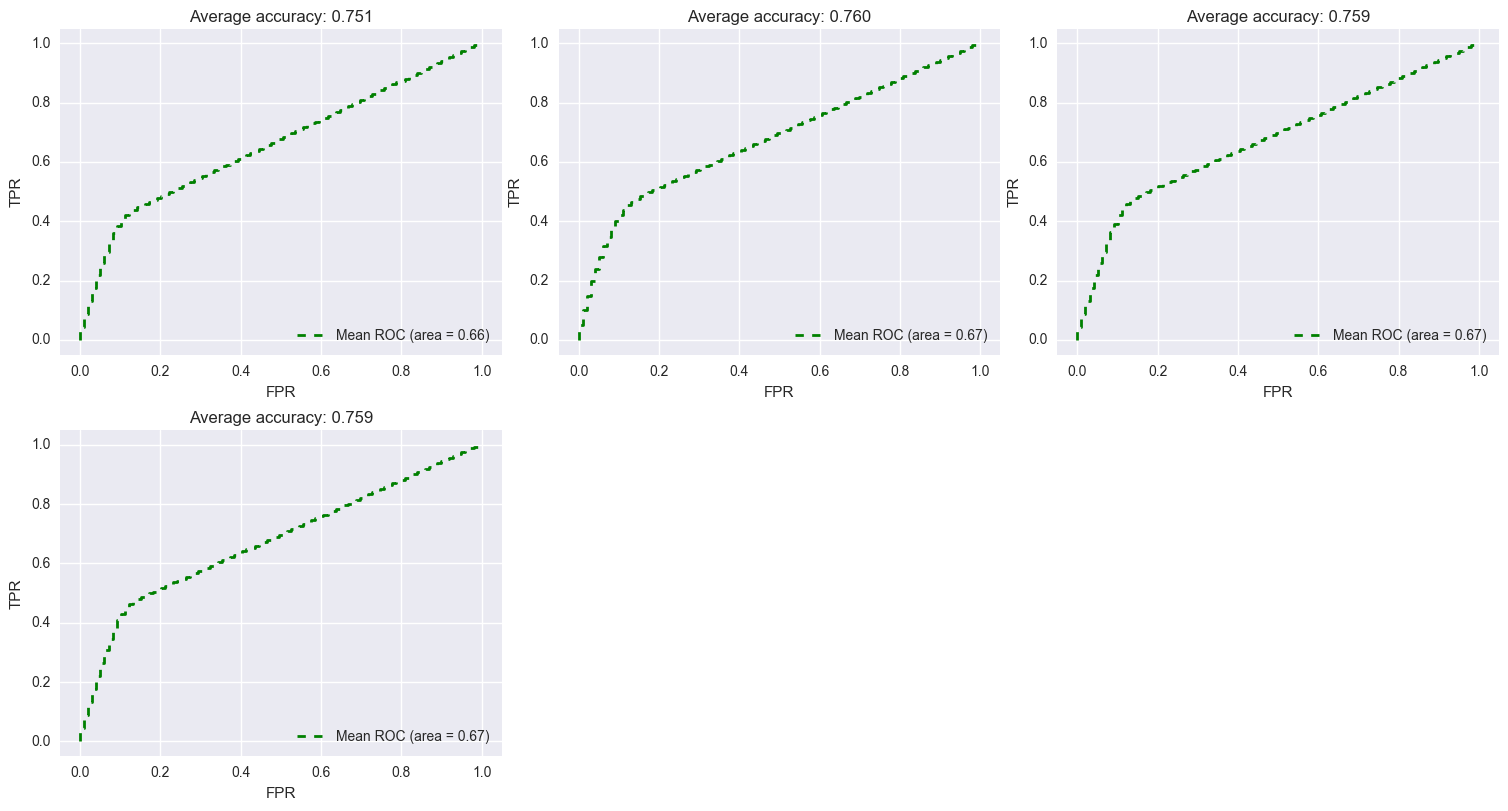

In [35]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Max Iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Random State = The seed of the pseudo random number generator to use when shuffling the data.

Average accuracy: 0.759 (+/-0.041) Random State:  None
Average accuracy: 0.760 (+/-0.033) Random State:  10
Average accuracy: 0.751 (+/-0.048) Random State:  100
Average accuracy: 0.763 (+/-0.027) Random State:  500
Average accuracy: 0.759 (+/-0.033) Random State:  1000
Average accuracy: 0.759 (+/-0.028) Random State:  1024


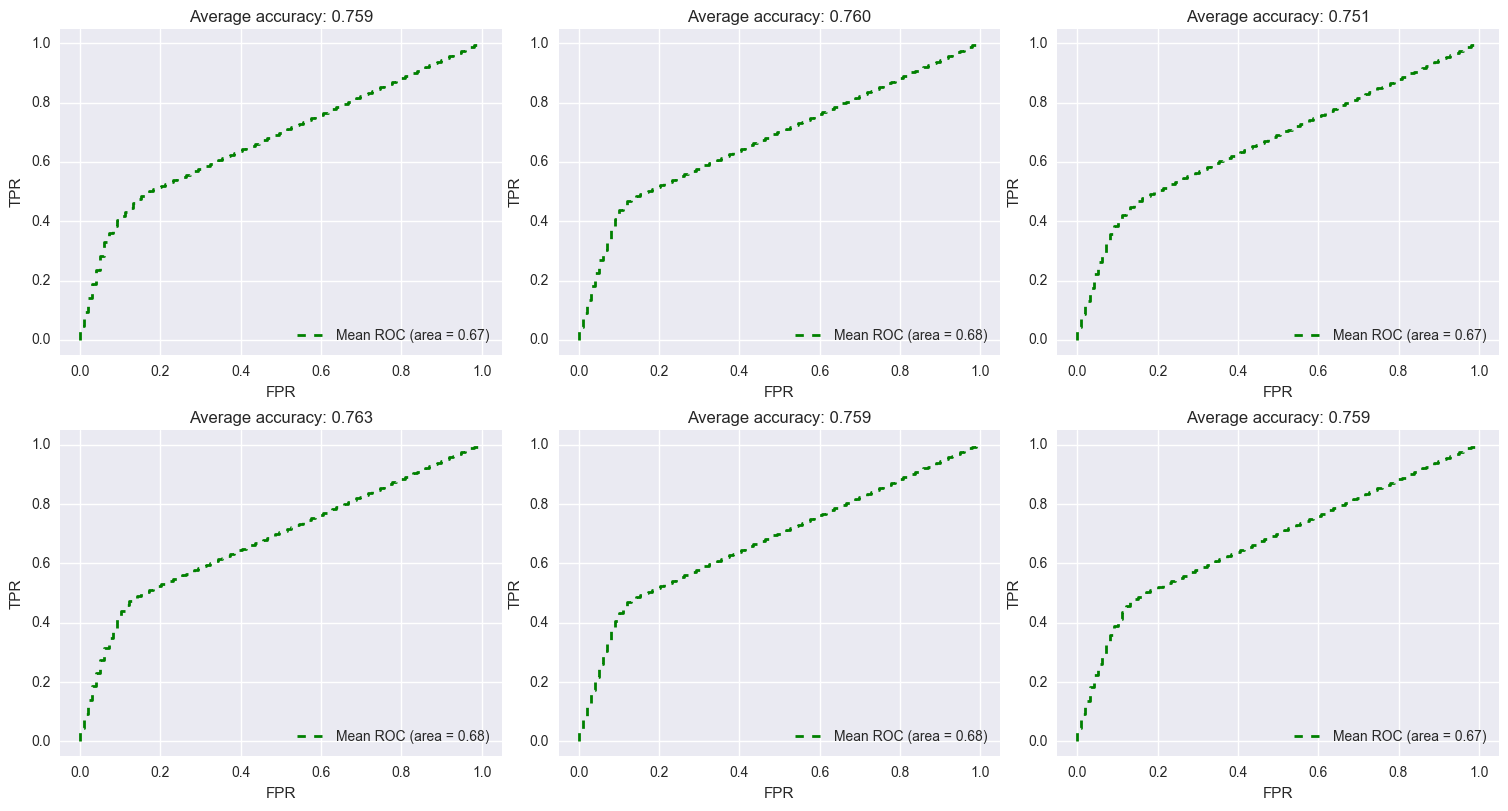

In [36]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Best Parameters using Greedy Approach

Average accuracy: 0.752 (+/-0.029)


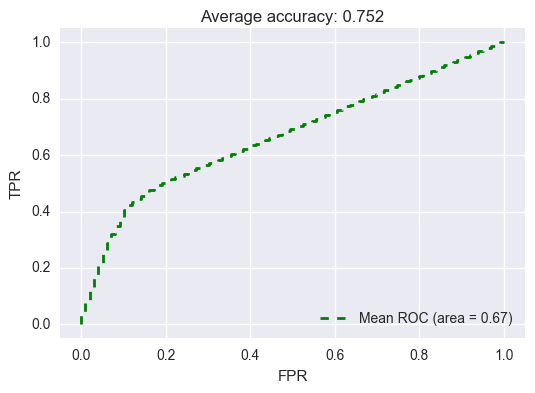

In [37]:
svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=1000)
print(algorithm(svm,colors,german_train,german_test,pos = 2))

SVM Best Parameters

In [38]:
svm

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=1000, tol=0.0001,
     verbose=0)

Our kNN implementation

In [39]:
X_train, X_test, y_train, y_test = train_test_split(german.iloc[:,:-1], german.iloc[:,-1:], test_size=0.20, random_state=4212)
train = pd.concat([X_train, y_train], axis=1)

In [40]:
predictions = []
for i,c in X_test.iterrows():
    kneighbors = knn(train,c,5)
    responses = majorityVote(kneighbors)
    predictions.append(responses)
mine_knn = pd.DataFrame( data={"predicted":predictions,"actual":y_test.values.ravel()} ) 
print ("accuracy_score: ", accuracy_score(mine_knn['actual'],mine_knn['predicted']))

accuracy_score:  0.68
